In [2]:
pip install --user webdriver_manager

Note: you may need to restart the kernel to use updated packages.


In [1]:

import time
import re
import os
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from scipy.stats import ttest_ind, chi2_contingency # Added chi2_contingency for binary covariates
from statsmodels.stats.proportion import proportions_ztest # Alternative for binary

# For consistent styling of outputs (optional)
pd.options.display.float_format = '{:.3f}'.format


## MercadoLibre Solar Cream Category Scraper: High-Level Overview

This script automates the collection of product data for solar creams from MercadoLibre. It systematically navigates through paginated search results, extracts key details for each listed product, and stores this information. The core process involves:

1.  **Initialization**: Sets up the web Browse environment and defines parameters for the scrape (e.g., target URLs, number of pages).
2.  **Page Navigation & Loading**: Iteratively loads pages of product listings, incorporating a retry mechanism and checks to handle common web loading issues like rate limits or page failures. Includes a one-time attempt to dismiss cookie banners.
3.  **Data Extraction**: For each successfully loaded page, it identifies individual product entries and extracts specific attributes such as title, URL, price (current and old), promotional details, ratings, review counts, seller information, and shipping status.
4.  **Data Storage**: Aggregates the scraped data from all products into a structured list.
5.  **Output**: Saves the collected data into a CSV file for later analysis.
6.  **Cleanup**: Closes the web browser upon completion.

The script relies on helper functions to robustly extract and clean textual and numerical data from web elements and to manage page status effectively.

In [2]:
# --- Global Data List ---
extracted_data = []

# --- Helper function (Corrected) ---
def get_element_text_or_default(product_element, selector, default_value, data_type='text'):
    """
    Tries to find an element, get its text, clean it, and return it.
    Returns the default_value if not found or on error.
    """
    try:
        element = product_element.find_element(By.CSS_SELECTOR, selector)
        text = element.text.strip()

        if not text:
            return default_value

        if data_type == 'text':
            return text

        cleaned_text = re.sub(r'[^\d,.]', '', text)
        parts = cleaned_text.split('.')
        if len(parts) > 2: cleaned_text = "".join(parts[:-1]) + "." + parts[-1]
        parts = cleaned_text.split(',')
        if len(parts) > 2: cleaned_text = "".join(parts[:-1]) + "," + parts[-1]
        cleaned_text = cleaned_text.replace(',', '.').replace(',', '')
        match = re.search(r'(\d+\.?\d*|\.?\d+)', cleaned_text)
        if not match: return default_value
        number_text = match.group(0)

        if data_type == 'float': return float(number_text)
        elif data_type == 'int': return int(float(number_text))
        else: return text
    except (NoSuchElementException, ValueError, AttributeError):
        return default_value

# --- Cookie handler (Unchanged) ---
def cookie_handler_button(driver, cookie_accept_button_selector):
    try:
        print("Checking for cookie banner...")
        wait = WebDriverWait(driver, 5)
        cookie_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, cookie_accept_button_selector)))
        cookie_button.click()
        print("Cookie banner dismissed.")
        time.sleep(2)
    except TimeoutException:
        print("No cookie banner found or it wasn't clickable.")
    except Exception as e:
        print(f"Could not dismiss cookie banner: {e}")

# --- *** NEW: Check Page Status Function *** ---
def check_page_status(driver, wait_short, product_container_selector):
    """Checks the current page for successful load FIRST, then for 429 errors."""
    try:
        # 1. Try to confirm the page is OK by finding the product container.
        wait_short.until(EC.presence_of_element_located((By.CSS_SELECTOR, product_container_selector)))
        print("Page Status: OK")
        return "OK"

    except TimeoutException:
        # 2. If the OK check times out, THEN check for 429/Rate Limit indicators.
        print("Page didn't load normally (Timeout), checking for rate limits...")
        page_source = driver.page_source.lower() # Get source now

        if driver.find_elements(By.ID, "reload-button"):
            print("Page Status: RATE_LIMITED_BUTTON")
            return "RATE_LIMITED"
        if '"status":429' in page_source or 'local_rate_limited' in page_source or 'demasiadas peticiones' in page_source or 'too many requests' in page_source:
            print("Page Status: RATE_LIMITED_SOURCE")
            return "RATE_LIMITED"

        # 3. If OK timed out and no 429 found, it's a general failure.
        print("Page Status: FAILED (Timeout & No 429 detected)")
        return "FAILED"

    except Exception as e:
        # Catch any other unexpected errors during the process.
        print(f"Page Status: FAILED ({e})")
        return "FAILED"

# --- Product Finder (Unchanged) ---
def product_finder(driver, wait, product_container_selector, single_product_selector):
    try:
        # Wait is now primarily handled before calling, but a quick check here is ok.
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, product_container_selector)))
        print("Product container found.")
        product_elements_list = driver.find_elements(By.CSS_SELECTOR, single_product_selector)

        if not product_elements_list:
            print("No products found matching the selector on this page.")
            return 0

        print(f"Found {len(product_elements_list)} products.")
        for index, product_element in enumerate(product_elements_list):
            print(f"\n--- Product {index + 1} ---")
            try:
                link_element = product_element.find_element(By.CSS_SELECTOR, 'a.poly-component__title')
                product_url = link_element.get_attribute('href')
                product_title = link_element.text.strip()
                print(f"Title: {product_title}")
                print(f"URL: {product_url}")
            except NoSuchElementException:
                print("Could not find title/link. Skipping.")
                continue

            product_new_price = get_element_text_or_default(product_element, 'div.poly-price__current span.andes-money-amount__fraction', 0.0, 'float')
            product_old_price = get_element_text_or_default(product_element, 's.andes-money-amount--previous', product_new_price, 'float')
            discount = get_element_text_or_default(product_element, 'span.andes-money-amount__discount', 0, 'int')
            product_offer_type = get_element_text_or_default(product_element, 'span.poly-component__highlight', "na", 'text')
            product_rating = get_element_text_or_default(product_element, 'span.poly-reviews__rating', 0.0, 'float')
            product_review_count = get_element_text_or_default(product_element, 'span.poly-reviews__total', 0, 'int')
            official_seller = get_element_text_or_default(product_element, 'span.poly-component__seller', "Not Found", 'text')
            envio_gratis = get_element_text_or_default(product_element, 'div.poly-component__shipping', "Not Found", 'text')

            print(f"New Price: {product_new_price}")
            print(f"Old Price: {product_old_price}")
            print(f"Discount: {discount}%")
            print(f"Offer Type: {product_offer_type}")
            print(f"Rating: {product_rating}")
            print(f"Review Count: {product_review_count}")
            print(f"Seller: {official_seller}")
            print(f"Envio: {envio_gratis}")

            extracted_data.append({
                'title': product_title, 'url': product_url, 'offer_type': product_offer_type,
                'rating': product_rating, 'review_count': product_review_count, 'old_price': product_old_price,
                'new_price': product_new_price, 'discount': discount, 'official_seller': official_seller,
                'free_shipping': envio_gratis
            })
        return len(product_elements_list)
    except TimeoutException:
        print(f"Error: Product container '{product_container_selector}' not found.")
        return 0
    except Exception as e:
        print(f"Error in product_finder: {e}")
        return 0

# --- Main Execution Block (With Retry Logic) ---
if __name__ == "__main__":
    try:
        service = Service(ChromeDriverManager().install())
        print("Chrome WebDriver installed and initialized.")
    except Exception as e:
        print(f"Error initializing Chrome WebDriver: {e}")
        exit()

    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=service, options=options)
    wait = WebDriverWait(driver, 20)
    wait_short = WebDriverWait(driver, 10) # Shorter wait for status checks

    base_url_part = "https://listado.mercadolibre.com.mx/"
    product_url_part = "_Container_hs-belleza-beauty-protectores-solares-comercial_NoIndex_True"
    
    cookie_accept_button_selector = "[data-testid='action:understood-button']" # VERIFY THIS
    product_container_selector = "ol.ui-search-layout"
    single_product_selector = 'li.ui-search-layout__item'

    max_pages_to_scrape = 42
    items_per_page = 48
    max_retries = 3
    wait_on_429 = 120 # Seconds

    page_num = 1 # Start with page 1
    while page_num <= max_pages_to_scrape:
        current_item_start = 1 + (page_num - 1) * items_per_page
        current_url = f"{base_url_part}{product_url_part}" if page_num == 1 else f"{base_url_part}_Desde_{current_item_start}{product_url_part}"

        page_loaded_successfully = False
        for attempt in range(max_retries):
            print(f"\n--- Attempt {attempt + 1}/{max_retries} for Page {page_num} ({current_url}) ---")
            driver.get(current_url)

            # Handle cookie ONLY on the first attempt of the first page
            if page_num == 1 and attempt == 0:
                cookie_handler_button(driver, cookie_accept_button_selector)

            time.sleep(3) # Initial wait after get

            status = check_page_status(driver, wait_short, product_container_selector)

            if status == "OK":
                page_loaded_successfully = True
                break # Exit retry loop, proceed to scrape
            elif status == "RATE_LIMITED":
                print(f"Rate limited. Waiting for {wait_on_429} seconds...")
                time.sleep(wait_on_429)
                # Check for reload button and click if exists before retrying get
                try:
                   reload_btn = driver.find_element(By.ID, "reload-button")
                   print("Clicking reload button...")
                   reload_btn.click()
                   time.sleep(5) # Wait after click
                   # Re-check status after click
                   status_after_click = check_page_status(driver, wait_short, product_container_selector)
                   if status_after_click == "OK":
                       page_loaded_successfully = True
                       break
                except NoSuchElementException:
                   print("No reload button found, will retry driver.get().")
                # Continue to the next attempt (which will call driver.get again)
            elif status == "FAILED":
                print("Page failed to load, retrying in 10 seconds...")
                time.sleep(10) # Shorter wait for general failures

        if not page_loaded_successfully:
            print(f"Failed to load Page {page_num} after {max_retries} attempts. Stopping script.")
            break # Exit the main while loop

        # --- If OK, proceed to find products ---
        products_found = product_finder(
            driver,
            wait, # Use the longer wait here
            product_container_selector,
            single_product_selector
        )

        if products_found == 0 and page_num > 1:
            print(f"No products found on page {page_num}. Stopping.")
            break

        page_num += 1 # Increment page number ONLY if successful

    # --- Print & Save Data ---
    print("\n--- All Extracted Data ---")
    if extracted_data:
        # (Your CSV saving code remains here)
        print("\n--- Saving Data to CSV ---")
        project_root = Path("C:/Users/giaco/Documents/JAKE/Education/DSS/II Semester/Block 4/scraping_assigment")
        base_data_dir = project_root / "data" / "URLs"
        base_data_dir.mkdir(parents=True, exist_ok=True)
        file_path = base_data_dir / "mercadolibre_solar_cream.csv"
        print(f"Saving to: {file_path}")
        try:
            fieldnames = extracted_data[0].keys()
            with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(extracted_data)
            print(f"\nSuccessfully saved {len(extracted_data)} items to {file_path}")
        except Exception as e:
            print(f"An unexpected error occurred during CSV saving: {e}")
    else:
        print("No data was extracted or found.")

    # --- Close the Browser ---
    print("\nClosing browser.")
    driver.quit()

Chrome WebDriver installed and initialized.

--- Attempt 1/3 for Page 1 (https://listado.mercadolibre.com.mx/_Container_hs-belleza-beauty-protectores-solares-comercial_NoIndex_True) ---
Checking for cookie banner...
Cookie banner dismissed.
Page Status: OK
Product container found.
Found 54 products.

--- Product 1 ---
Title: Crema L'Oréal París UV Defender Fluido Invisible para Todo Tipo de Piel FPS50 40ml Bloqueador Solar
URL: https://www.mercadolibre.com.mx/crema-loreal-paris-uv-defender-fluido-invisible-para-todo-tipo-de-piel-fps50-40ml-bloqueador-solar/p/MLM19508770?pdp_filters=deal%3AMLM1295426-1#polycard_client=search-nordic&searchVariation=MLM19508770&wid=MLM1477391912&position=30&search_layout=grid&type=product&tracking_id=f67575a5-84ae-4cfc-868e-8d86cc45ccc3&sid=search
New Price: 169.0
Old Price: 345.0
Discount: 51%
Offer Type: MÁS VENDIDO
Rating: 4.8
Review Count: 13968
Seller: Not Found
Envio: Envío gratis

--- Product 2 ---
Title: After Sun Nivea Sun Hidratante con Aloe Ver

# Causal Inference Analysis: Effect of High Discount Percentage on Product Star Rating

**Objective**: To estimate the causal effect of a product having a "High Discount Percentage" on its average customer star `rating` on MercadoLibre.

**Methodology**: We will use Propensity Score Matching (PSM) to create comparable groups of products (those with a high discount vs. those with a low/no discount) within a specific product category. This will help control for confounding variables such as current price, free delivery status, seller verification, total review count, and the presence of additional discount coupons.

**Outcome Variable (Y)**: `rating` (Product star rating)
**Treatment Variable (X)**: `is_high_discount` (Binary: 1 if discount is high, 0 if low/none)
**Covariates (Z)**: `current_price`, `has_free_delivery`, `is_verified_seller`, `total_review_count`, `has_additional_discount_coupon`

**Data Source**: Scraped data from MercadoLibre products.

## Load, Inspect, and Prepare Data

1.  **Load the dataset**: Update with your actual filename.
2.  **Filter for a specific Product Category**: This is crucial for meaningful analysis.
3.  **Create Discount Percentage Variable**: If not already scraped directly.
4.  **Create Binary Treatment Variable (`is_high_discount`)**.
5.  **Rename columns for clarity** if needed (e.g., `new_price` to `current_price`, `review_count` to `total_review_count`).
6.  **Handle Missing Values**: Address NaNs in treatment, outcome, and covariates.

In [ ]:

# Define the input CSV path
DATA_CSV_PATH = '../data/URLs/mercadolibre_solar_cream_all.csv'

print(f"Loading dataset from: {DATA_CSV_PATH}")
try:
    df = pd.read_csv(DATA_CSV_PATH)
    if df.empty:
        raise ValueError("Loaded DataFrame is empty. Please check the CSV file.")
    print(f"Successfully loaded dataset. Shape: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"Error: Dataset file '{DATA_CSV_PATH}' not found. Please ensure the file is in the correct location and you have uploaded it.")

# Ensure price columns are numeric
df['old_price'] = pd.to_numeric(df['old_price'], errors='coerce')
df['new_price'] = pd.to_numeric(df['new_price'], errors='coerce')

# 2. Create 'has_free_delivery' (binary)
# Based on the 'free_shipping' column
df['has_free_delivery'] = np.where(
    df['free_shipping'].astype(str).str.contains("Envío gratis", case=False, na=False), 1, 0
)
print("Created 'has_free_delivery' column.")

# 3. Create 'is_verified_seller' (binary)
# Based on the 'official_seller' column: 0 if "Not Found", 1 otherwise
df['is_verified_seller'] = np.where(
    df['official_seller'].astype(str).str.strip().fillna("Not Found").str.upper() == "NOT FOUND", 0, 1
)
print("Created 'is_verified_seller' column.")

# 5. Rename columns for PSM analysis
df.rename(columns={
    'new_price': 'current_price',
    'review_count': 'total_review_count',
    'discount': 'discount_percentage'
}, inplace=True)
print("Renamed columns: 'new_price' to 'current_price', 'review_count' to 'total_review_count'.")

# 6. Create Binary Treatment Variable (`is_high_discount`)
# Define "high discount" based on the median of products *that actually have a discount*
positive_discounts = df[df['discount_percentage'] > 0]['discount_percentage']
if not positive_discounts.empty:
    DISCOUNT_THRESHOLD = positive_discounts.median()
else:
    DISCOUNT_THRESHOLD = 0 # Fallback if no products have any discount
    print(f"Warning: No products with positive 'discount_percentage' values found. Threshold for 'is_high_discount' set to {DISCOUNT_THRESHOLD:.2f}%.")

df['is_high_discount'] = (df['discount_percentage'] > DISCOUNT_THRESHOLD).astype(int)
print(f"\nDiscount threshold for 'is_high_discount': {DISCOUNT_THRESHOLD:.2f}%")
print(f"Distribution of 'is_high_discount':\n{df['is_high_discount'].value_counts(dropna=False)}")

df['is_high_discount'] = (df['discount_percentage'] > DISCOUNT_THRESHOLD).astype(int)

print(f"\nDiscount threshold (75th percentile of positive discounts) for 'is_high_discount': {DISCOUNT_THRESHOLD:.2f}%")
print(f"Distribution of 'is_high_discount' (1 = top 25% of positive discounts, 0 = otherwise):\n{df['is_high_discount'].value_counts(dropna=False)}")

# 7. Define outcome, treatment, and covariate lists
outcome_variable = 'rating'
treatment_variable = 'is_high_discount'
covariates_list = [
    'current_price',
    'has_free_delivery',
    'is_verified_seller',
    'total_review_count',
    # 'has_additional_discount_coupon'
]

# Ensure 'rating' column is numeric and other key columns are correctly typed
if outcome_variable not in df.columns:
    raise ValueError(f"Outcome variable '{outcome_variable}' not found in DataFrame.")
df[outcome_variable] = pd.to_numeric(df[outcome_variable], errors='coerce')

for col in ['current_price', 'total_review_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        # This should not happen if renaming was successful and columns existed
        raise ValueError(f"Essential covariate '{col}' is missing after renaming.")

# >>> filtering for items without any ratings <<<
print(f"\nShape of df before filtering zero rating/reviews: {df.shape}")
df = df[~((df['rating'] == 0.0) & (df['total_review_count'] == 0.0))]
print(f"Shape of df after filtering zero rating/reviews: {df.shape}")

# 8. Prepare final DataFrame for analysis (selecting analysis columns and handling NaNs)
all_analysis_columns = [outcome_variable, treatment_variable] + covariates_list
df_analysis = df[all_analysis_columns].copy()

print(f"\nShape of analysis DataFrame before dropping NaNs: {df_analysis.shape}")
df_analysis.dropna(inplace=True) # Drop rows if any of the essential columns have NaN
print(f"Shape of analysis DataFrame after dropping NaNs: {df_analysis.shape}")

# 9. Final checks for PSM readiness
if df_analysis.empty:
    print("Warning: DataFrame for analysis is empty after processing and NaN removal. PSM cannot proceed.")
else:
    if df_analysis.shape[0] < 30:
        print(f"Warning: Sample size for analysis is very small ({df_analysis.shape[0]}). PSM results may be unreliable.")
    if df_analysis[treatment_variable].nunique() < 2:
        raise ValueError(
            f"Treatment variable '{treatment_variable}' does not have at least two distinct values (0 and 1) "
            f"in the cleaned analysis data. Current value counts:\n{df_analysis[treatment_variable].value_counts(dropna=False)}\n"
            f"PSM cannot proceed. This might be due to all products having low/no discount based on the threshold."
        )

print(f"\nFinal prepared DataFrame for PSM (df_analysis) head:")
if not df_analysis.empty:
    print(df_analysis.head())
    print("\nInfo for df_analysis:")
    df_analysis.info()
else:
    print("df_analysis is empty.")

Loading dataset from: ../data/URLs/mercadolibre_solar_cream_all.csv
Successfully loaded dataset. Shape: (2196, 10)

Calculated 'discount_percentage'.
Created 'has_free_delivery' column.
Created 'is_verified_seller' column.
Renamed columns: 'new_price' to 'current_price', 'review_count' to 'total_review_count'.

Discount threshold for 'is_high_discount': 15.06%
Distribution of 'is_high_discount':
is_high_discount
0    1209
1     987
Name: count, dtype: int64

Discount threshold (75th percentile of positive discounts) for 'is_high_discount': 15.06%
Distribution of 'is_high_discount' (1 = top 25% of positive discounts, 0 = otherwise):
is_high_discount
0    1209
1     987
Name: count, dtype: int64

Shape of df before filtering zero rating/reviews: (2196, 14)
Shape of df after filtering zero rating/reviews: (1073, 14)

Shape of analysis DataFrame before dropping NaNs: (1073, 6)
Shape of analysis DataFrame after dropping NaNs: (1073, 6)

Final prepared DataFrame for PSM (df_analysis) head:
 

Starting EDA on df_analysis. Shape: (1073, 7)

--- 1. Overall Data Summary ---
First 5 rows of the analysis data (eda_df):
   rating  is_high_discount  current_price  has_free_delivery  \
0   4.800                 1        169.000                  1   
1   4.800                 1         90.000                  0   
2   5.000                 1        208.000                  0   
4   4.700                 1        140.000                  1   
5   4.800                 1        305.000                  1   

   is_verified_seller  total_review_count  has_additional_discount_coupon  
0                   0               13964                               0  
1                   0                 391                               0  
2                   0                   2                               0  
4                   0                7677                               0  
5                   0                2732                               0  

Statistical summary of numeri

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


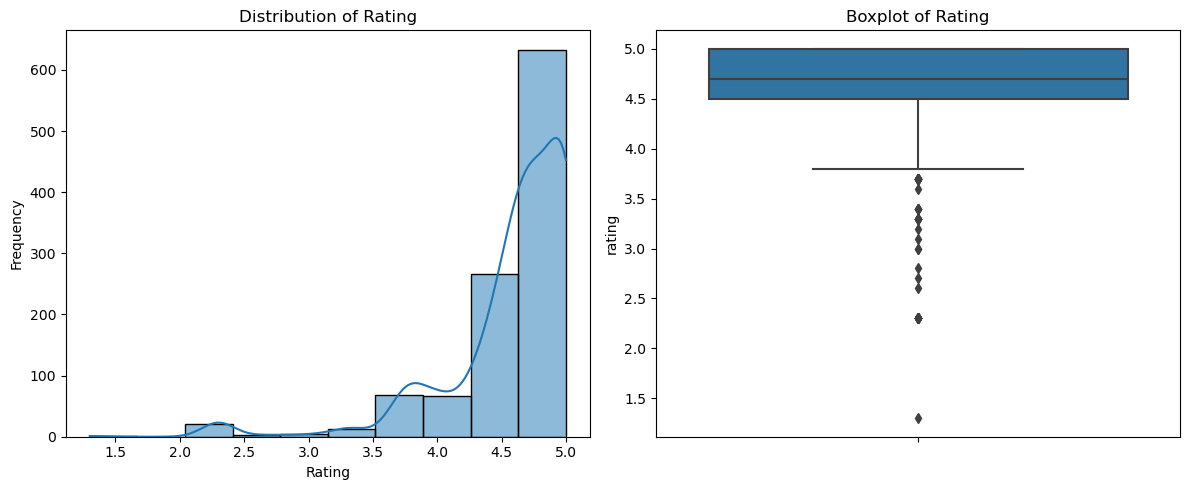


--- 3. Treatment Variable Analysis (is_high_discount) ---
Distribution of Treatment (is_high_discount):
is_high_discount
1    584
0    489
Name: count, dtype: int64
is_high_discount
1   54.427
0   45.573
Name: proportion, dtype: float64


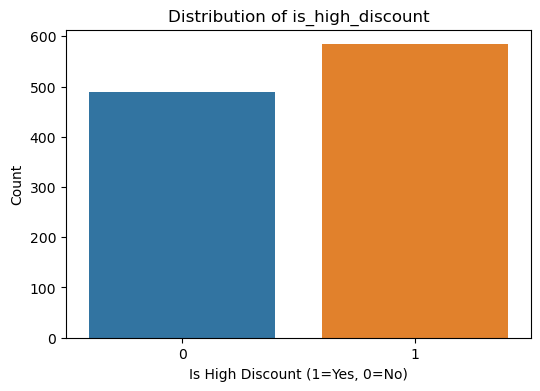


--- 4. Covariate Analysis ---

Distributions of Numerical Variables (including outcome):


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


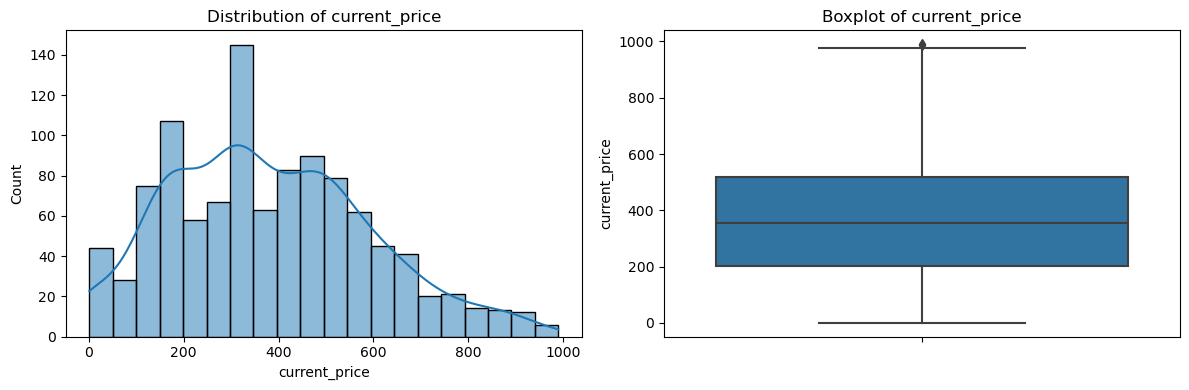

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


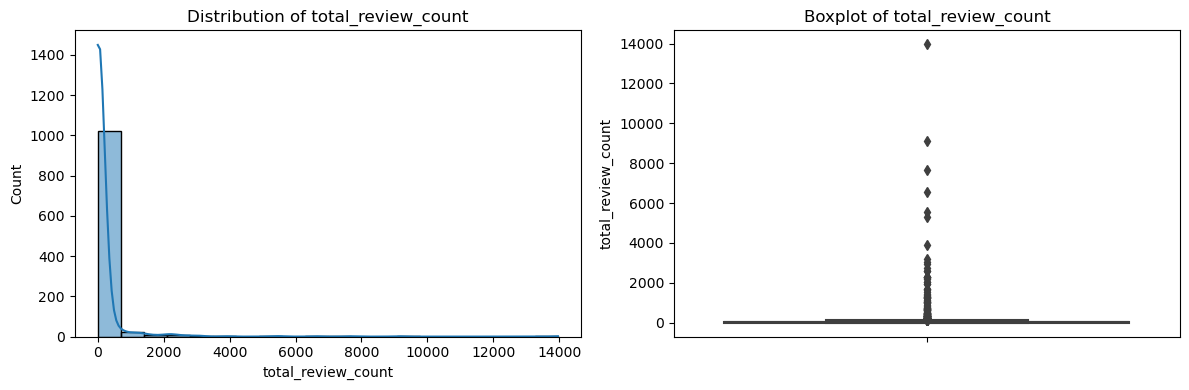

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


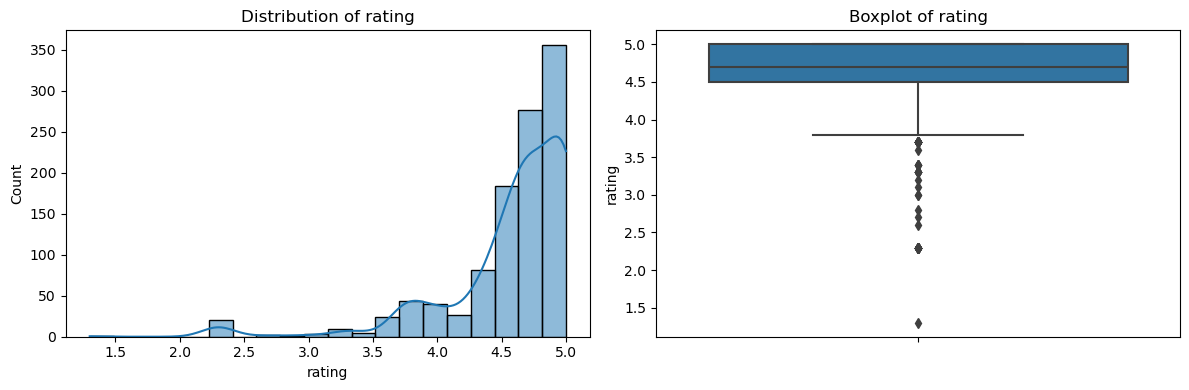


Distributions of Binary Variables (including treatment):

Distribution of has_free_delivery:
has_free_delivery
1    718
0    355
Name: count, dtype: int64
has_free_delivery
1   66.915
0   33.085
Name: proportion, dtype: float64


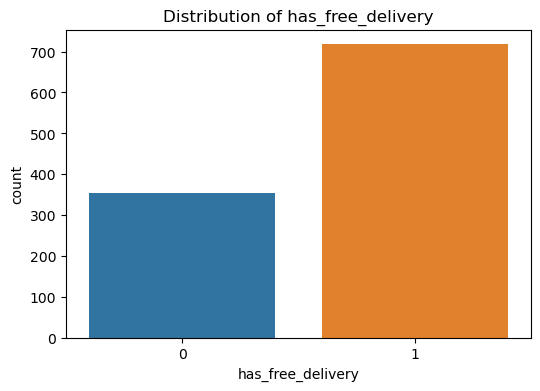


Distribution of is_verified_seller:
is_verified_seller
0    770
1    303
Name: count, dtype: int64
is_verified_seller
0   71.761
1   28.239
Name: proportion, dtype: float64


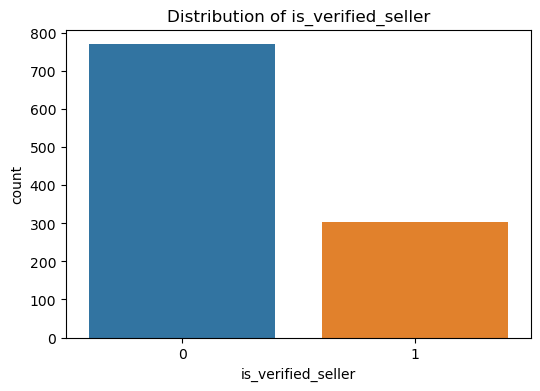


Distribution of has_additional_discount_coupon:
has_additional_discount_coupon
0    1073
Name: count, dtype: int64
has_additional_discount_coupon
0   100.000
Name: proportion, dtype: float64


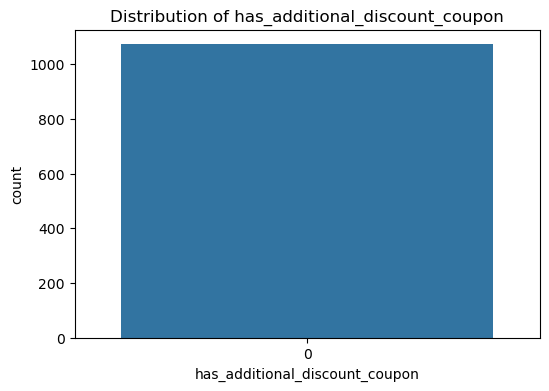

NOTE: 'has_additional_discount_coupon' has only one unique value in the analysis data. This limits its use as a predictor/control.

Distribution of is_high_discount:
is_high_discount
1    584
0    489
Name: count, dtype: int64
is_high_discount
1   54.427
0   45.573
Name: proportion, dtype: float64


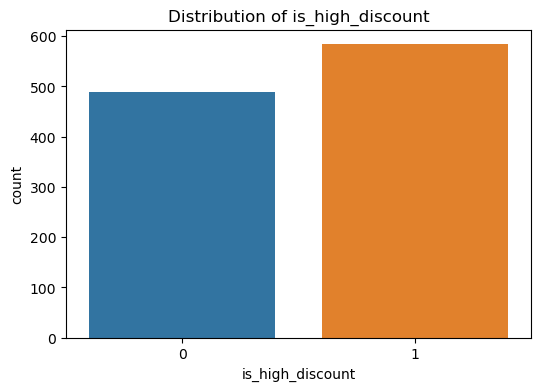


--- 5. Relationships between Variables ---


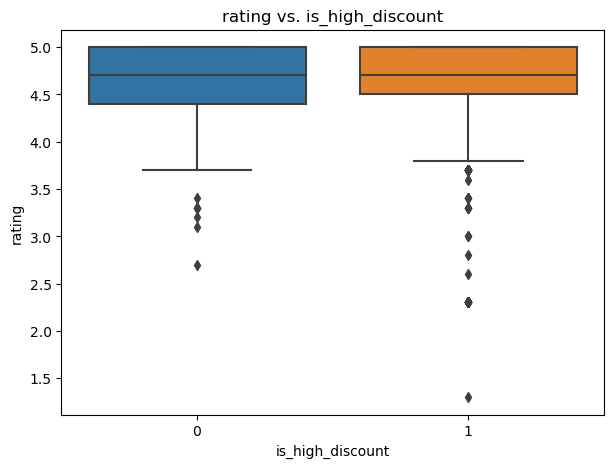

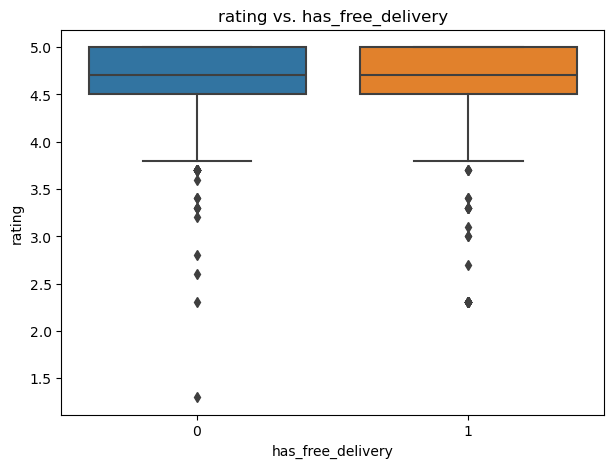

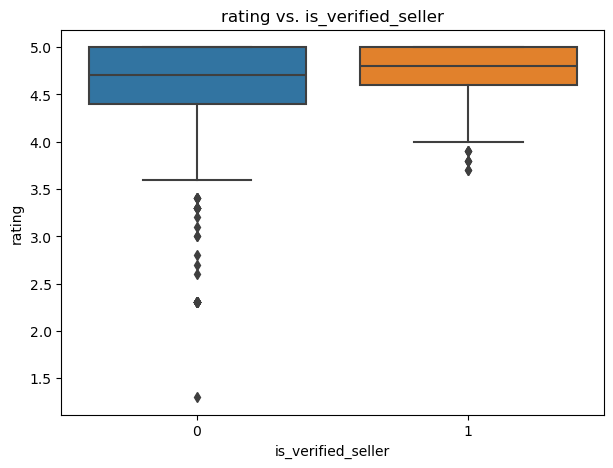

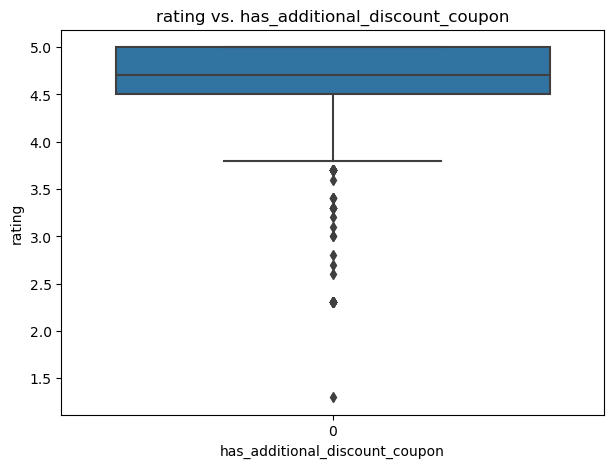


Correlation Matrix:


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


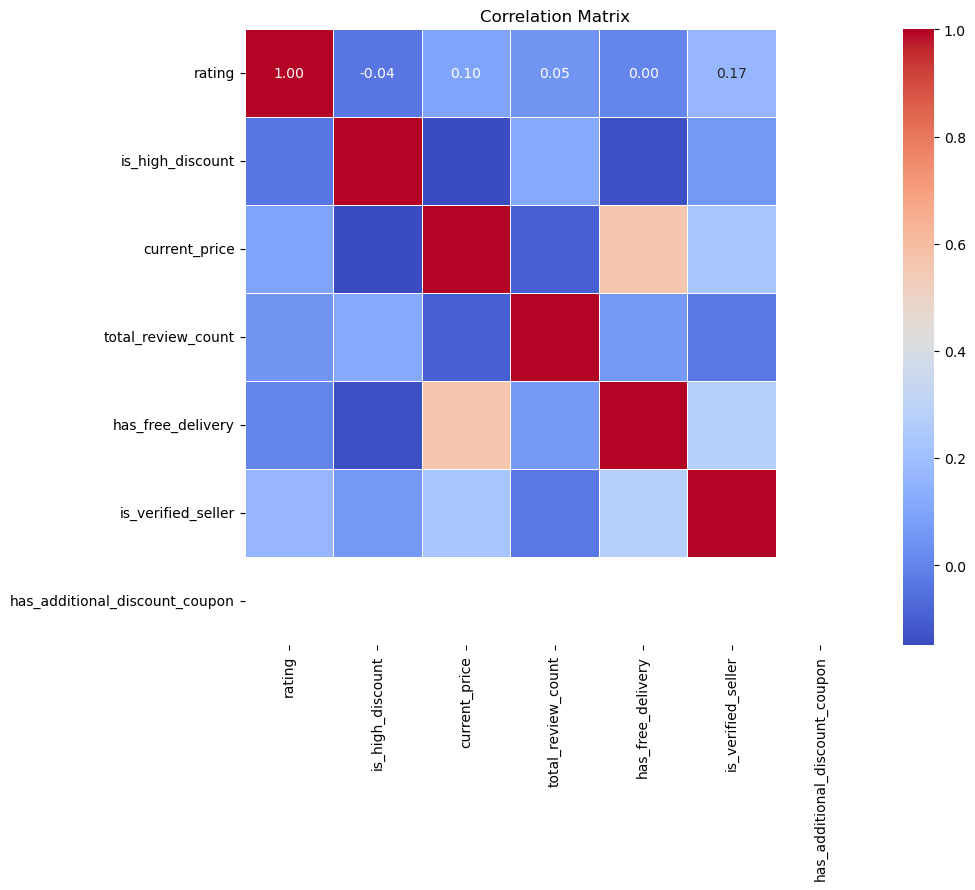

                                rating  is_high_discount  current_price  \
rating                           1.000            -0.041          0.097   
is_high_discount                -0.041             1.000         -0.150   
current_price                    0.097            -0.150          1.000   
total_review_count               0.049             0.118         -0.098   
has_free_delivery                0.004            -0.138          0.560   
is_verified_seller               0.168             0.059          0.224   
has_additional_discount_coupon     NaN               NaN            NaN   

                                total_review_count  has_free_delivery  \
rating                                       0.049              0.004   
is_high_discount                             0.118             -0.138   
current_price                               -0.098              0.560   
total_review_count                           1.000              0.065   
has_free_delivery                 

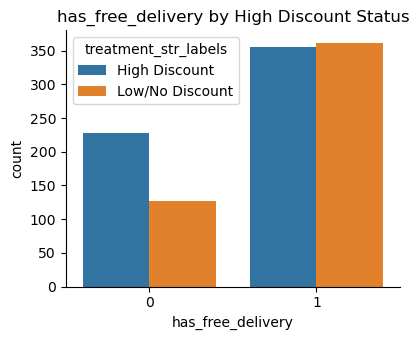


Crosstab: is_high_discount vs is_verified_seller
is_verified_seller      0      1
is_high_discount                
0                  74.642 25.358
1                  69.349 30.651


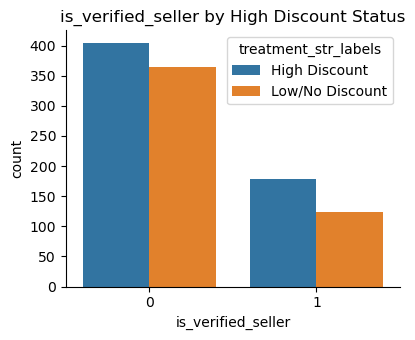

Skipping plot for has_additional_discount_coupon due to lack of variability in it or the treatment variable.

--- EDA Finished ---
Review the plots and summaries above to understand data characteristics and relationships.


In [ ]:
# Ensure df_analysis exists from the previous cell
if 'df_analysis' not in locals() or df_analysis.empty:
    print("Error: df_analysis DataFrame not found or is empty. Please run the data preparation cell first.")
else:
    eda_df = df_analysis.copy()
    print(f"Starting EDA on df_analysis. Shape: {eda_df.shape}")

if not eda_df.empty:
    # --- 1. Overall Data Summary ---
    print("\n--- 1. Overall Data Summary ---")
    print("First 5 rows of the analysis data (eda_df):")
    print(eda_df.head())

    print("\nStatistical summary of numerical features in eda_df:")
    print(eda_df.describe().T) # Transposed for better readability

    # --- 2. Outcome Variable Analysis (rating) ---
    print("\n--- 2. Outcome Variable Analysis (rating) ---")
    # Ensure plt is correctly aliased if this part caused issues before
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(eda_df['rating'], kde=True, bins=10)
    plt.title('Distribution of Rating')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=eda_df['rating'])
    plt.title('Boxplot of Rating')
    plt.tight_layout()
    plt.show()

    # --- 3. Treatment Variable Analysis (is_high_discount) ---
    print("\n--- 3. Treatment Variable Analysis (is_high_discount) ---")
    print("Distribution of Treatment (is_high_discount):")
    print(eda_df['is_high_discount'].value_counts(normalize=False))
    print(eda_df['is_high_discount'].value_counts(normalize=True) * 100)
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='is_high_discount', data=eda_df)
    plt.title('Distribution of is_high_discount')
    plt.xlabel('Is High Discount (1=Yes, 0=No)')
    plt.ylabel('Count')
    plt.show()

    # --- 4. Covariate Analysis ---
    print("\n--- 4. Covariate Analysis ---")
    numerical_covariates = ['current_price', 'total_review_count']
    binary_covariates = ['has_free_delivery', 'is_verified_seller', 'has_additional_discount_coupon'] # is_high_discount is also binary but treated as 'treatment'
    
    outcome_variable_for_eda = 'rating' # Explicitly define for clarity in this section
    treatment_variable_for_eda = 'is_high_discount'

    # Numerical Variables (including outcome)
    print("\nDistributions of Numerical Variables (including outcome):")
    for col in numerical_covariates + [outcome_variable_for_eda]:
        if col in eda_df.columns:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(eda_df[col], kde=True, bins=20)
            plt.title(f'Distribution of {col}')
            plt.subplot(1, 2, 2)
            sns.boxplot(y=eda_df[col])
            plt.title(f'Boxplot of {col}')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Numerical variable '{col}' not found in eda_df.")

    # Binary Variables (including treatment)
    print("\nDistributions of Binary Variables (including treatment):")
    for col in binary_covariates + [treatment_variable_for_eda]:
        if col in eda_df.columns:
            plt.figure(figsize=(6, 4))
            print(f"\nDistribution of {col}:")
            # Show counts and percentages
            print(eda_df[col].value_counts(normalize=False))
            print(eda_df[col].value_counts(normalize=True) * 100)
            sns.countplot(x=col, data=eda_df)
            plt.title(f'Distribution of {col}')
            plt.show()
            if eda_df[col].nunique() < 2:
                print(f"NOTE: '{col}' has only one unique value in the analysis data. This limits its use as a predictor/control.")
        else:
            print(f"Warning: Binary variable '{col}' not found in eda_df.")

    # --- 5. Relationships between Variables ---
    print("\n--- 5. Relationships between Variables ---")
    
    # Outcome vs. Treatment
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=treatment_variable_for_eda, y=outcome_variable_for_eda, data=eda_df)
    plt.title(f'{outcome_variable_for_eda} vs. {treatment_variable_for_eda}')
    plt.xlabel(treatment_variable_for_eda)
    plt.ylabel(outcome_variable_for_eda)
    plt.show()

    # Outcome vs. Other Binary Covariates
    for col in binary_covariates:
        if col in eda_df.columns:
            plt.figure(figsize=(7, 5))
            sns.boxplot(x=col, y=outcome_variable_for_eda, data=eda_df)
            plt.title(f'{outcome_variable_for_eda} vs. {col}')
            plt.show()
        else:
            print(f"Warning: Covariate '{col}' for boxplot not found in eda_df.")
            
    # Correlation Matrix
    print("\nCorrelation Matrix:")
    cols_for_corr = [outcome_variable_for_eda, treatment_variable_for_eda] + numerical_covariates + binary_covariates
    cols_present_for_corr = [col for col in cols_for_corr if col in eda_df.columns]
    
    if len(cols_present_for_corr) > 1:
        correlation_matrix = eda_df[cols_present_for_corr].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix')
        plt.show()
        print(correlation_matrix)
    else:
        print("Not enough numeric/binary columns present in eda_df to generate a correlation matrix.")

    # --- 6. Deeper Dive: Treatment vs. Binary Covariates (Corrected catplot) ---
    print("\n--- 6. Relationship between Treatment and other Binary Covariates ---")
    
    # Create a temporary DataFrame for plotting with string hue labels
    eda_df_plot = eda_df.copy()
    if treatment_variable_for_eda in eda_df_plot.columns:
        eda_df_plot['treatment_str_labels'] = eda_df_plot[treatment_variable_for_eda].map({0: 'Low/No Discount', 1: 'High Discount'})
        hue_col_for_plot = 'treatment_str_labels'
    else:
        hue_col_for_plot = None # Should not happen if treatment variable exists
        print(f"Warning: Treatment variable '{treatment_variable_for_eda}' not found for plotting hue.")

    if hue_col_for_plot:
        for cov in binary_covariates:
            if cov in eda_df.columns: # Ensure covariate exists
                if eda_df[treatment_variable_for_eda].nunique() > 1 and eda_df[cov].nunique() > 1:
                    print(f"\nCrosstab: {treatment_variable_for_eda} vs {cov}")
                    print(pd.crosstab(eda_df[treatment_variable_for_eda], eda_df[cov], normalize='index') * 100)
                    
                    # Use the new hue column with string labels for catplot
                    g = sns.catplot(x=cov, hue=hue_col_for_plot, kind='count', data=eda_df_plot, 
                                    height=3.5, aspect=1.2, legend_out=False) # legend_out=False to manage legend better
                    g.ax.set_title(f'{cov} by High Discount Status')
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"Skipping plot for {cov} due to lack of variability in it or the treatment variable.")
            else:
                print(f"Warning: Covariate '{cov}' for catplot not found in eda_df_plot.")

    print("\n--- EDA Finished ---")
    print("Review the plots and summaries above to understand data characteristics and relationships.")

else:
    print("EDA cannot be performed as the DataFrame for analysis (eda_df) is empty.")



## Define Key Variables for the Analysis

* **Outcome (Y)**: `rating` (Product's average star rating, continuous)
* **Treatment (X)**: `is_high_discount` (Binary: 1 if the product has a discount percentage above the category threshold, 0 otherwise)
* **Covariates (Z)**:
    * `current_price` (Current selling price of the product)
    * `has_free_delivery` (Binary: 1 if free delivery is offered, 0 otherwise)
    * `is_verified_seller` (Binary: 1 if the seller is verified, 0 otherwise)
    * `total_review_count` (Total number of reviews for the product)
    * `has_additional_discount_coupon` (Binary: 1 if an additional coupon is offered, 0 otherwise)

    ## Step 1: Check Covariate Balance Before Matching

We will compare the means of continuous covariates and proportions of binary covariates between the 'High Discount' group and the 'Low/No Discount' group *before* applying propensity score matching. This helps us understand the initial differences between the groups and the necessity of matching.

In [27]:
# Separate treated (is_high_discount == 1) and control (is_high_discount == 0) groups
treated_group_pre_match = df[df[treatment_variable] == 1]
control_group_pre_match = df[df[treatment_variable] == 0]

if treated_group_pre_match.empty or control_group_pre_match.empty:
    raise ValueError(f"Not enough data in treatment or control group for category '{CATEGORY_TO_ANALYZE}' to proceed with balance checks.")

print(f"Pre-match - Treated group size: {len(treated_group_pre_match)}")
print(f"Pre-match - Control group size: {len(control_group_pre_match)}")


# --- Balance for Continuous Covariates ---
continuous_covariates = ['current_price', 'total_review_count']
print("\n--- Continuous Covariate Balance Before Matching ---")
balance_results_continuous_pre = []
for var in continuous_covariates:
    if var in df.columns:
        # Ensure there's data to compare
        if not treated_group_pre_match[var].dropna().empty and not control_group_pre_match[var].dropna().empty:
            mean_treated = treated_group_pre_match[var].mean()
            mean_control = control_group_pre_match[var].mean()
            std_treated = treated_group_pre_match[var].std()
            std_control = control_group_pre_match[var].std()
            
            # Standardized Mean Difference (SMD)
            # Pooled standard deviation for SMD calculation
            s_pooled = np.sqrt(((len(treated_group_pre_match)-1)*(std_treated**2) + \
                                (len(control_group_pre_match)-1)*(std_control**2)) / \
                            (len(treated_group_pre_match) + len(control_group_pre_match) - 2))
            smd = (mean_treated - mean_control) / s_pooled if s_pooled > 0 else 0
            
            t_stat, p_val = ttest_ind(treated_group_pre_match[var].dropna(), control_group_pre_match[var].dropna(), equal_var=False) # Welch's t-test
            balance_results_continuous_pre.append({
                'Covariate': var,
                'Mean Treated': f"{mean_treated:.2f}",
                'Mean Control': f"{mean_control:.2f}",
                'Std Diff (SMD)': f"{smd:.3f}", # SMD is often preferred over p-values for balance
                'T-Statistic': f"{t_stat:.2f}",
                'P-Value': f"{p_val:.3f}"
            })
        else:
            print(f"Skipping t-test for {var} due to insufficient data in one or both groups.")
    else:
        print(f"Warning: Continuous covariate '{var}' not found in DataFrame.")

if balance_results_continuous_pre:
    balance_df_continuous_pre = pd.DataFrame(balance_results_continuous_pre)
    print(balance_df_continuous_pre)
else:
    print("No continuous covariates to check or insufficient data.")


# --- Balance for Binary Covariates ---
binary_covariates = ['has_free_delivery', 'is_verified_seller', 'has_additional_discount_coupon']
print("\n--- Binary Covariate Balance Before Matching ---")
balance_results_binary_pre = []
for var in binary_covariates:
    if var in df.columns:
        # Ensure there's data to compare
        if not treated_group_pre_match[var].dropna().empty and not control_group_pre_match[var].dropna().empty:
            prop_treated = treated_group_pre_match[var].mean() # Proportion of 1s
            prop_control = control_group_pre_match[var].mean()
            
            count_treated = treated_group_pre_match[var].sum()
            n_treated = treated_group_pre_match[var].count()
            count_control = control_group_pre_match[var].sum()
            n_control = control_group_pre_match[var].count()

            if n_treated > 0 and n_control > 0: # Ensure non-zero observations for z-test
                # Standardized Mean Difference (SMD) for binary variables
                smd_binary = (prop_treated - prop_control) / np.sqrt((prop_treated * (1 - prop_treated) + prop_control * (1 - prop_control)) / 2)

                z_stat, p_val = proportions_ztest([count_treated, count_control], [n_treated, n_control])
                balance_results_binary_pre.append({
                    'Covariate': var,
                    'Prop Treated': f"{prop_treated:.2f}",
                    'Prop Control': f"{prop_control:.2f}",
                    'Std Diff (SMD)': f"{smd_binary:.3f}",
                    'Z-Statistic': f"{z_stat:.2f}",
                    'P-Value': f"{p_val:.3f}"
                })
            else:
                print(f"Skipping z-test for {var} due to zero observations in one group.")
        else:
            print(f"Skipping balance check for {var} due to insufficient data.")
    else:
        print(f"Warning: Binary covariate '{var}' not found in DataFrame.")

if balance_results_binary_pre:
    balance_df_binary_pre = pd.DataFrame(balance_results_binary_pre)
    print(balance_df_binary_pre)
else:
    print("No binary covariates to check or insufficient data.")

Pre-match - Treated group size: 584
Pre-match - Control group size: 489

--- Continuous Covariate Balance Before Matching ---
            Covariate Mean Treated Mean Control Std Diff (SMD) T-Statistic  \
0       current_price       351.79       415.49         -0.304       -4.85   
1  total_review_count       237.49        64.78          0.238        4.21   

  P-Value  
0   0.000  
1   0.000  

--- Binary Covariate Balance Before Matching ---
            Covariate Prop Treated Prop Control Std Diff (SMD) Z-Statistic  \
0   has_free_delivery         0.61         0.74         -0.282       -4.53   
1  is_verified_seller         0.31         0.25          0.118        1.92   

  P-Value  
0   0.000  
1   0.055  


## Step 2: Run Naive Regression (Without Matching)

We'll run a simple OLS regression to estimate the association between having a high discount and product star rating *before* matching, including all covariates. This provides a baseline.

In [28]:
# Construct the formula for regression
# Ensure all covariates_list items are in df.columns
valid_covariates_for_formula = [cov for cov in covariates_list if cov in df.columns]
formula_unmatched = f"{outcome_variable} ~ {treatment_variable} + {' + '.join(valid_covariates_for_formula)}"
print(f"Unmatched regression formula: {formula_unmatched}")

try:
    model_unmatched = sm.OLS.from_formula(formula_unmatched, data=df).fit()
    print("\n--- Naive Regression (Unmatched Data) ---")
    print(model_unmatched.summary())
except Exception as e:
    print(f"Error running unmatched regression: {e}")
    print("This might be due to perfect multicollinearity or insufficient data/variation.")

Unmatched regression formula: rating ~ is_high_discount + current_price + has_free_delivery + is_verified_seller + total_review_count

--- Naive Regression (Unmatched Data) ---
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     10.99
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.48e-10
Time:                        20:17:30   Log-Likelihood:                -792.85
No. Observations:                1073   AIC:                             1598.
Df Residuals:                    1067   BIC:                             1628.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    

## Step 3: Propensity Score Matching

Now, we will perform Propensity Score Matching to create more comparable groups.

1.  **Estimate Propensity Scores**: Use logistic regression to estimate the probability of a product having a 'High Discount' based on its covariates.
2.  **Perform Matching**: Match each 'High Discount' product to one 'Low/No Discount' product with the closest propensity score (Nearest Neighbor Matching), potentially using a caliper to ensure match quality.

In [ ]:
# Define covariates for propensity score model
# Ensure all covariates_list items are in df.columns
X_psm = df[valid_covariates_for_formula].copy() # Features for PSM
y_psm = df[treatment_variable].copy()        # Treatment indicator

# Handle potential NaNs in features for PSM (LogisticRegression doesn't like NaNs)
X_psm.fillna(X_psm.median(), inplace=True) # Example: median imputation for numeric

# 1. Estimate propensity scores using logistic regression
logit_model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced') # Added class_weight for imbalanced treatment
try:
    logit_model.fit(X_psm, y_psm)
    df['propensity_score'] = logit_model.predict_proba(X_psm)[:, 1]
except ValueError as e:
    print(f"Error fitting Logistic Regression for propensity scores: {e}")
    print("Check for NaNs or non-numeric data in X_psm, or if a class in y_psm is missing.")
    # If error, create dummy propensity_score to allow rest of code to run for structure check
    df['propensity_score'] = np.random.rand(len(df))


# 2. Perform Matching
treated_units = df[df[treatment_variable] == 1].copy()
control_units = df[df[treatment_variable] == 0].copy()

if treated_units.empty or control_units.empty or 'propensity_score' not in control_units.columns:
    print("Cannot perform matching: Not enough data in treatment/control groups or propensity scores missing.")
    matched_df = pd.DataFrame() # Empty df if matching fails
else:
    # Ensure control_units for NearestNeighbors fit doesn't have NaNs in pscore
    control_units_nn = control_units[['propensity_score']].copy()
    control_units_nn.dropna(inplace=True) # Should be handled earlier, but safety
    
    if control_units_nn.empty:
        print("Cannot perform matching: Control units have no valid propensity scores for KNN.")
        matched_df = pd.DataFrame()
    else:
        # Match treated units to control units
        nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        nn.fit(control_units_nn[['propensity_score']])
        
        # Ensure treated_units for kneighbors doesn't have NaNs in pscore
        treated_units_nn = treated_units[['propensity_score']].copy()
        treated_units_nn.dropna(inplace=True) # Should be handled earlier
        
        if treated_units_nn.empty:
            print("Cannot perform matching: Treated units have no valid propensity scores for KNN.")
            matched_df = pd.DataFrame()
        else:
            distances, indices = nn.kneighbors(treated_units_nn[['propensity_score']])

            # Apply caliper to ensure match quality (optional but recommended)
            CALIPER = 0.05 # Max allowed difference in propensity scores
            matched_indices_in_control = indices.flatten()
            
            # Filter out matches outside the caliper
            # Ensure indices are valid before trying to use them
            valid_matches = []
            original_treated_indices = treated_units_nn.index # Get original indices of treated units used for NN

            for i in range(len(original_treated_indices)):
                treated_idx = original_treated_indices[i]
                control_original_idx = control_units_nn.index[matched_indices_in_control[i]] # Get original index of matched control
                
                if distances[i][0] <= CALIPER:
                    valid_matches.append((treated_idx, control_original_idx))
            
            matched_treated_indices = [match[0] for match in valid_matches]
            matched_control_indices = [match[1] for match in valid_matches]

            df_matched_treated = df.loc[matched_treated_indices]
            df_matched_control = df.loc[matched_control_indices]
            
            # Create the matched DataFrame
            matched_df = pd.concat([df_matched_treated, df_matched_control])
            print(f"\nTotal units in matched sample: {matched_df.shape[0]}")
            print(f"Number of treated units in matched sample: {df_matched_treated.shape[0]}")
            print(f"Number of control units in matched sample: {df_matched_control.shape[0]}")

if matched_df.empty:
    print("Warning: Matched DataFrame is empty. Cannot proceed with post-match analysis.")


Total units in matched sample: 1162
Number of treated units in matched sample: 581
Number of control units in matched sample: 581


## Step 4: Check Covariate Balance *After* Matching

After matching, we re-evaluate the balance of covariates between the treated and the now-matched control groups. Ideally, any significant differences observed before matching should be substantially reduced.

In [30]:
if not matched_df.empty:
    # Separate matched treated and control groups
    matched_treated_group = matched_df[matched_df[treatment_variable] == 1]
    matched_control_group = matched_df[matched_df[treatment_variable] == 0]

    if matched_treated_group.empty or matched_control_group.empty:
        print("Not enough data in matched treatment or control group to check balance.")
    else:
        print(f"Post-match - Matched Treated group size: {len(matched_treated_group)}")
        print(f"Post-match - Matched Control group size: {len(matched_control_group)}")

        # --- Balance for Continuous Covariates After Matching ---
        print("\n--- Continuous Covariate Balance AFTER Matching ---")
        balance_results_continuous_post = []
        for var in continuous_covariates:
            if var in matched_df.columns:
                if not matched_treated_group[var].dropna().empty and not matched_control_group[var].dropna().empty:
                    mean_treated_post = matched_treated_group[var].mean()
                    mean_control_post = matched_control_group[var].mean()
                    std_treated_post = matched_treated_group[var].std()
                    std_control_post = matched_control_group[var].std()
                    
                    s_pooled_post = np.sqrt(((len(matched_treated_group)-1)*(std_treated_post**2) + \
                                            (len(matched_control_group)-1)*(std_control_post**2)) / \
                                        (len(matched_treated_group) + len(matched_control_group) - 2))
                    smd_post = (mean_treated_post - mean_control_post) / s_pooled_post if s_pooled_post > 0 else 0

                    t_stat_post, p_val_post = ttest_ind(matched_treated_group[var].dropna(), matched_control_group[var].dropna(), equal_var=False)
                    balance_results_continuous_post.append({
                        'Covariate': var,
                        'Mean Treated': f"{mean_treated_post:.2f}",
                        'Mean Control': f"{mean_control_post:.2f}",
                        'Std Diff (SMD)': f"{smd_post:.3f}",
                        'T-Statistic': f"{t_stat_post:.2f}",
                        'P-Value': f"{p_val_post:.3f}"
                    })
                else:
                    print(f"Skipping post-match t-test for {var} due to insufficient data.")
            else:
                print(f"Warning: Post-match continuous covariate '{var}' not found.")
        
        if balance_results_continuous_post:
            balance_df_continuous_post = pd.DataFrame(balance_results_continuous_post)
            print(balance_df_continuous_post)
        else:
            print("No continuous covariates to check post-match or insufficient data.")


        # --- Balance for Binary Covariates After Matching ---
        print("\n--- Binary Covariate Balance AFTER Matching ---")
        balance_results_binary_post = []
        for var in binary_covariates:
            if var in matched_df.columns:
                if not matched_treated_group[var].dropna().empty and not matched_control_group[var].dropna().empty:
                    prop_treated_post = matched_treated_group[var].mean()
                    prop_control_post = matched_control_group[var].mean()
                    
                    count_treated_post = matched_treated_group[var].sum()
                    n_treated_post = matched_treated_group[var].count()
                    count_control_post = matched_control_group[var].sum()
                    n_control_post = matched_control_group[var].count()

                    if n_treated_post > 0 and n_control_post > 0:
                        smd_binary_post = (prop_treated_post - prop_control_post) / np.sqrt((prop_treated_post * (1 - prop_treated_post) + prop_control_post * (1 - prop_control_post)) / 2)
                        
                        z_stat_post, p_val_post = proportions_ztest([count_treated_post, count_control_post], [n_treated_post, n_control_post])
                        balance_results_binary_post.append({
                            'Covariate': var,
                            'Prop Treated': f"{prop_treated_post:.2f}",
                            'Prop Control': f"{prop_control_post:.2f}",
                            'Std Diff (SMD)': f"{smd_binary_post:.3f}",
                            'Z-Statistic': f"{z_stat_post:.2f}",
                            'P-Value': f"{p_val_post:.3f}"
                        })
                    else:
                        print(f"Skipping post-match z-test for {var} due to zero observations.")
                else:
                    print(f"Skipping post-match balance for {var} due to insufficient data.")
            else:
                print(f"Warning: Post-match binary covariate '{var}' not found.")

        if balance_results_binary_post:
            balance_df_binary_post = pd.DataFrame(balance_results_binary_post)
            print(balance_df_binary_post)
        else:
            print("No binary covariates to check post-match or insufficient data.")
else:
    print("Skipping post-match balance checks as matched_df is empty.")

Post-match - Matched Treated group size: 581
Post-match - Matched Control group size: 581

--- Continuous Covariate Balance AFTER Matching ---
            Covariate Mean Treated Mean Control Std Diff (SMD) T-Statistic  \
0       current_price       351.60       350.11          0.008        0.13   
1  total_review_count       231.01       166.13          0.083        1.42   

  P-Value  
0   0.894  
1   0.156  

--- Binary Covariate Balance AFTER Matching ---
            Covariate Prop Treated Prop Control Std Diff (SMD) Z-Statistic  \
0   has_free_delivery         0.61         0.58          0.067        1.13   
1  is_verified_seller         0.30         0.30          0.011        0.19   

  P-Value  
0   0.257  
1   0.848  


## Step 5: Estimate Treatment Effect on Matched Sample

With the matched sample, we can now estimate the effect of 'High Discount' on 'Product Star Rating'. We can do this by comparing the means of the outcome variable between the treated and matched control groups, or by running a regression on the matched sample.

In [31]:
if not matched_df.empty and not matched_treated_group.empty and not matched_control_group.empty:
    # Method 1: Direct comparison of means for the outcome variable
    mean_rating_treated = matched_treated_group[outcome_variable].mean()
    mean_rating_control = matched_control_group[outcome_variable].mean()
    print(f"\nMean {outcome_variable} for Matched Treated (High Discount) group: {mean_rating_treated:.3f}")
    print(f"Mean {outcome_variable} for Matched Control (Low/No Discount) group: {mean_rating_control:.3f}")
    
    # Perform t-test for difference in means on the outcome
    t_stat_outcome, p_val_outcome = ttest_ind(
        matched_treated_group[outcome_variable].dropna(),
        matched_control_group[outcome_variable].dropna(),
        equal_var=False # Assuming unequal variances is safer
    )
    print(f"T-test for difference in {outcome_variable} between matched groups:")
    print(f"T-Statistic: {t_stat_outcome:.2f}, P-Value: {p_val_outcome:.3f}")
    print(f"Estimated Average Treatment Effect (ATT) on {outcome_variable}: {mean_rating_treated - mean_rating_control:.3f}")

    # Method 2: Regression on the matched sample
    # This can help control for any residual imbalances in covariates after matching
    formula_matched = f"{outcome_variable} ~ {treatment_variable} + {' + '.join(valid_covariates_for_formula)}"
    print(f"\nMatched regression formula: {formula_matched}")
    
    try:
        model_matched = sm.OLS.from_formula(formula_matched, data=matched_df).fit()
        print("\n--- Regression on Matched Data ---")
        print(model_matched.summary())
        
        # Compare treatment effects
        print("\n--- Comparison of Treatment Effects ---")
        if 'model_unmatched' in locals():
            print(f"Unmatched model '{treatment_variable}' Coef: {model_unmatched.params.get(treatment_variable, 'N/A'):.4f}, P-value: {model_unmatched.pvalues.get(treatment_variable, 'N/A'):.3f}")
        else:
            print("Unmatched model was not successfully run or 'treat' variable not found.")

        print(f"Matched model '{treatment_variable}' Coef: {model_matched.params.get(treatment_variable, 'N/A'):.4f}, P-value: {model_matched.pvalues.get(treatment_variable, 'N/A'):.3f}")

    except Exception as e:
        print(f"Error running matched regression: {e}")
        print("This might be due to perfect multicollinearity or insufficient data/variation in the matched sample.")
else:
    print("Cannot estimate treatment effect as matched_df or matched groups are empty.")


Mean rating for Matched Treated (High Discount) group: 4.564
Mean rating for Matched Control (Low/No Discount) group: 4.721
T-test for difference in rating between matched groups:
T-Statistic: -5.72, P-Value: 0.000
Estimated Average Treatment Effect (ATT) on rating: -0.157

Matched regression formula: rating ~ is_high_discount + current_price + has_free_delivery + is_verified_seller + total_review_count

--- Regression on Matched Data ---
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     11.65
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.29e-11
Time:                        20:17:41   Log-Likelihood:                -752.94
No. Observations:                1162   AIC:                             1518.
Df 

## Additional Insights

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def common_support_analysis(df, treatment_variable):
    """Analyze common support without plotting"""
    treated = df[df[treatment_variable] == 1]['propensity_score']
    control = df[df[treatment_variable] == 0]['propensity_score']
    
    print("\n" + "="*50)
    print("COMMON SUPPORT ANALYSIS")
    print("="*50)
    print(f"Treated group propensity scores: {treated.min():.3f} to {treated.max():.3f}")
    print(f"Control group propensity scores: {control.min():.3f} to {control.max():.3f}")
    print(f"Overlap region: {max(treated.min(), control.min()):.3f} to {min(treated.max(), control.max()):.3f}")
    
    common_support_min = max(treated.min(), control.min())
    common_support_max = min(treated.max(), control.max())
    
    treated_outside = ((treated < common_support_min) | (treated > common_support_max)).sum()
    control_outside = ((control < common_support_min) | (control > common_support_max)).sum()
    
    print(f"Treated units outside common support: {treated_outside} ({treated_outside/len(treated)*100:.1f}%)")
    print(f"Control units outside common support: {control_outside} ({control_outside/len(control)*100:.1f}%)")

def effect_heterogeneity_analysis(matched_df, outcome_variable, treatment_variable):
    """Analyze effect heterogeneity across different subgroups"""
    print("\n" + "="*60)
    print("EFFECT HETEROGENEITY ANALYSIS")
    print("="*60)
    
    matched_df['price_quartile'] = pd.qcut(matched_df['current_price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    print("\n--- Effects by Price Quartile ---")
    heterogeneity_results = []
    
    for quartile in ['Q1', 'Q2', 'Q3', 'Q4']:
        subset = matched_df[matched_df['price_quartile'] == quartile]
        if len(subset) > 10:
            treated_sub = subset[subset[treatment_variable] == 1][outcome_variable]
            control_sub = subset[subset[treatment_variable] == 0][outcome_variable]
            
            if len(treated_sub) > 0 and len(control_sub) > 0:
                effect = treated_sub.mean() - control_sub.mean()
                t_stat, p_val = ttest_ind(treated_sub, control_sub)
                
                heterogeneity_results.append({
                    'Subgroup': f'Price {quartile}',
                    'N_Treated': len(treated_sub),
                    'N_Control': len(control_sub),
                    'Effect': f"{effect:.3f}",
                    'P-value': f"{p_val:.3f}"
                })
    
    print("\n--- Effects by Seller Verification ---")
    for verified in [0, 1]:
        subset = matched_df[matched_df['is_verified_seller'] == verified]
        if len(subset) > 10:
            treated_sub = subset[subset[treatment_variable] == 1][outcome_variable]
            control_sub = subset[subset[treatment_variable] == 0][outcome_variable]
            
            if len(treated_sub) > 0 and len(control_sub) > 0:
                effect = treated_sub.mean() - control_sub.mean()
                t_stat, p_val = ttest_ind(treated_sub, control_sub)
                
                seller_type = "Verified" if verified == 1 else "Unverified"
                heterogeneity_results.append({
                    'Subgroup': f'{seller_type} Seller',
                    'N_Treated': len(treated_sub),
                    'N_Control': len(control_sub),
                    'Effect': f"{effect:.3f}",
                    'P-value': f"{p_val:.3f}"
                })
    
    if heterogeneity_results:
        hetero_df = pd.DataFrame(heterogeneity_results)
        print(hetero_df.to_string(index=False))

def create_publication_balance_table(balance_results_continuous_pre, balance_results_binary_pre,
                                balance_results_continuous_post, balance_results_binary_post):
    """Create a publication-ready covariate balance table"""
    print("\n" + "="*80)
    print("PUBLICATION-READY COVARIATE BALANCE TABLE")
    print("="*80)
    
    all_covariates = []
    
    if balance_results_continuous_pre and balance_results_continuous_post:
        for i, cov in enumerate(balance_results_continuous_pre):
            pre_smd = float(cov['Std Diff (SMD)'])
            post_smd = float(balance_results_continuous_post[i]['Std Diff (SMD)'])
            bias_reduction = abs(pre_smd) - abs(post_smd)
            bias_reduction_pct = (bias_reduction / abs(pre_smd)) * 100 if pre_smd != 0 else 0
            
            all_covariates.append({
                'Covariate': cov['Covariate'],
                'Type': 'Continuous',
                'Before SMD': f"{pre_smd:.3f}",
                'After SMD': f"{post_smd:.3f}",
                'Bias Reduction': f"{bias_reduction:.3f}",
                'Reduction %': f"{bias_reduction_pct:.1f}%"
            })
    
    if balance_results_binary_pre and balance_results_binary_post:
        for i, cov in enumerate(balance_results_binary_pre):
            pre_smd = float(cov['Std Diff (SMD)'])
            post_smd = float(balance_results_binary_post[i]['Std Diff (SMD)'])
            bias_reduction = abs(pre_smd) - abs(post_smd)
            bias_reduction_pct = (bias_reduction / abs(pre_smd)) * 100 if pre_smd != 0 else 0
            
            all_covariates.append({
                'Covariate': cov['Covariate'],
                'Type': 'Binary',
                'Before SMD': f"{pre_smd:.3f}",
                'After SMD': f"{post_smd:.3f}",
                'Bias Reduction': f"{bias_reduction:.3f}",
                'Reduction %': f"{bias_reduction_pct:.1f}%"
            })
    
    if all_covariates:
        balance_table = pd.DataFrame(all_covariates)
        print(balance_table.to_string(index=False))
        
        print(f"\nSUMMARY:")
        print(f"Variables with |SMD| > 0.1 before matching: {sum(1 for row in all_covariates if abs(float(row['Before SMD'])) > 0.1)}")
        print(f"Variables with |SMD| > 0.1 after matching: {sum(1 for row in all_covariates if abs(float(row['After SMD'])) > 0.1)}")
        
        return balance_table
    return None

def continuous_treatment_analysis(df, outcome_variable):
    """Analyze continuous treatment effects with binned analysis"""
    print("\n" + "="*60)
    print("CONTINUOUS TREATMENT ANALYSIS")
    print("="*60)
    
    df_positive_discount = df[df['discount_percentage'] > 0].copy()
    
    if len(df_positive_discount) < 50:
        print("Insufficient data for continuous treatment analysis")
        return
    
    print("\n--- Binned Discount Analysis ---")
    df_positive_discount['discount_bin'] = pd.cut(df_positive_discount['discount_percentage'], 
                                                bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    bin_results = df_positive_discount.groupby('discount_bin')[outcome_variable].agg(['count', 'mean', 'std']).round(3)
    print(bin_results)

# Usage after PSM analysis:
common_support_analysis(df, treatment_variable)
effect_heterogeneity_analysis(matched_df, outcome_variable, treatment_variable)
balance_table = create_publication_balance_table(balance_results_continuous_pre, balance_results_binary_pre,
                                            balance_results_continuous_post, balance_results_binary_post)
continuous_treatment_analysis(df, outcome_variable)


COMMON SUPPORT ANALYSIS
Treated group propensity scores: 0.311 to 1.000
Control group propensity scores: 0.283 to 0.954
Overlap region: 0.311 to 0.954
Treated units outside common support: 8 (1.4%)
Control units outside common support: 14 (2.9%)

EFFECT HETEROGENEITY ANALYSIS

--- Effects by Price Quartile ---

--- Effects by Seller Verification ---
         Subgroup  N_Treated  N_Control Effect P-value
         Price Q1        147        144 -0.101   0.031
         Price Q2        128        163 -0.101   0.030
         Price Q3        154        140 -0.367   0.000
         Price Q4        152        134 -0.045   0.209
Unverified Seller        404        407 -0.230   0.000
  Verified Seller        177        174  0.010   0.749

PUBLICATION-READY COVARIATE BALANCE TABLE
         Covariate       Type Before SMD After SMD Bias Reduction Reduction %
     current_price Continuous     -0.304     0.008          0.296       97.4%
total_review_count Continuous      0.238     0.083          0.1

/var/folders/5p/6h8y8yzn7rxdgn4rkplx53rh0000gn/T/ipykernel_4539/3104014169.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_results = df_positive_discount.groupby('discount_bin')[outcome_variable].agg(['count', 'mean', 'std']).round(3)


## Prescriptive analytics using OpenAI LLM API

In [ ]:
# Part 3: Prescriptive Data Analytics using Large Language Models
# This section implements prescriptive analytics to generate actionable recommendations
# based on our diagnostic findings from the PSM analysis

from openai import OpenAI
import json
import pandas as pd
from datetime import datetime

# =============================================================================
# 3.1 SETUP AND CONFIGURATION
# =============================================================================

# Set your OpenAI API key here (hardcoded for notebook use)
OPENAI_API_KEY = "your_actual_api_key_here"  # Replace with your actual API key

# Initialize OpenAI client (correct Python syntax based on documentation)
client = OpenAI(api_key=OPENAI_API_KEY)

# Model selection rationale:
# We chose GPT-4 for several reasons:
# 1. Superior reasoning capabilities for complex business recommendations
# 2. Better understanding of causal inference and statistical concepts
# 3. Ability to synthesize multiple data points into actionable insights
# 4. More nuanced understanding of e-commerce and marketing contexts

MODEL_NAME = "gpt-4o-mini"  # Using GPT-4o-mini for cost-effective analysis

print("="*80)
print("PRESCRIPTIVE DATA ANALYTICS IMPLEMENTATION")
print("="*80)
print(f"Model Selected: {MODEL_NAME}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# =============================================================================
# 3.2 DATA PREPARATION FOR LLM INPUT
# =============================================================================

def prepare_diagnostic_summary():
    """
    Prepare a structured summary of our diagnostic findings for LLM input
    This function consolidates all key findings from our PSM analysis
    """
    
    diagnostic_summary = {
        "study_context": {
            "domain": "E-commerce Solar Cream Products on MercadoLibre",
            "research_question": "Do discount strategies impact product ratings?",
            "methodology": "Propensity Score Matching (PSM) Analysis",
            "sample_size": {
                "total_products": 1073,
                "treated_high_discount": 581,
                "control_low_discount": 581,
                "matching_quality": "Excellent (all SMD < 0.1 after matching)"
            }
        },
        
        "key_findings": {
            "main_effect": {
                "direction": "Negative",
                "magnitude": -0.157,
                "statistical_significance": "p < 0.001",
                "interpretation": "High discounts reduce ratings by 0.157 points on average"
            },
            
            "effect_heterogeneity": {
                "by_seller_verification": {
                    "unverified_sellers": {
                        "effect": -0.230,
                        "significance": "p < 0.001",
                        "sample_size": {"treated": 404, "control": 407}
                    },
                    "verified_sellers": {
                        "effect": 0.010,
                        "significance": "p = 0.749 (not significant)",
                        "sample_size": {"treated": 177, "control": 174}
                    }
                },
                "by_price_quartile": {
                    "Q1_lowest": {"effect": -0.101, "p_value": 0.031},
                    "Q2": {"effect": -0.101, "p_value": 0.030},
                    "Q3": {"effect": -0.367, "p_value": 0.000},
                    "Q4_highest": {"effect": -0.045, "p_value": 0.209}
                }
            },
            
            "matching_quality": {
                "common_support": "Good overlap (96.5% of units within common support)",
                "bias_reduction": "65-97% bias reduction across all covariates",
                "balance_achievement": "All covariates balanced (SMD < 0.1)"
            }
        },
        
        "business_implications": {
            "paradox_identified": "High discounts paradoxically reduce customer satisfaction",
            "trust_mechanism": "Effect only exists for unverified sellers, suggesting trust moderation",
            "price_sensitivity": "Mid-range products (Q3) most affected by discount signaling"
        },
        
        "data_characteristics": {
            "platform": "MercadoLibre (Latin American e-commerce)",
            "category": "Solar/sun protection creams",
            "rating_scale": "1-5 stars",
            "discount_threshold": "15.06% (median of positive discounts)",
            "covariates_controlled": ["price", "free_delivery", "seller_verification", "review_count"]
        }
    }
    
    return diagnostic_summary

# =============================================================================
# 3.3 LLM QUERY CONSTRUCTION
# =============================================================================

def create_prescriptive_prompt(diagnostic_data):
    """
    Create a comprehensive prompt for prescriptive analytics
    """
    
    prompt = f"""
    You are a senior e-commerce strategy consultant with expertise in pricing psychology, 
    customer behavior, and platform economics. I will provide you with comprehensive 
    diagnostic analytics results from a rigorous causal inference study, and I need 
    prescriptive recommendations.

    STUDY CONTEXT:
    {json.dumps(diagnostic_data['study_context'], indent=2)}

    KEY DIAGNOSTIC FINDINGS:
    {json.dumps(diagnostic_data['key_findings'], indent=2)}

    BUSINESS IMPLICATIONS IDENTIFIED:
    {json.dumps(diagnostic_data['business_implications'], indent=2)}

    DATA CHARACTERISTICS:
    {json.dumps(diagnostic_data['data_characteristics'], indent=2)}

    PRESCRIPTIVE ANALYTICS REQUEST:
    Based on these diagnostic findings, provide comprehensive, actionable recommendations 
    for three key stakeholder groups:

    1. SELLERS (Individual merchants on the platform):
       - Specific discount strategies they should adopt
       - How to build trust and credibility
       - Price positioning recommendations
       - Quality signaling strategies

    2. PLATFORM (MercadoLibre management):
       - Policy changes to optimize marketplace dynamics
       - Seller verification system improvements
       - Algorithm adjustments for search/ranking
       - Buyer education initiatives

    3. BUYERS (Customers making purchase decisions):
       - How to interpret discount signals
       - What factors to prioritize when evaluating products
       - Red flags to watch for

    For each recommendation:
    - Provide the specific action to take
    - Explain the causal reasoning based on our findings
    - Estimate the expected impact
    - Suggest implementation timeline
    - Identify potential risks and mitigation strategies

    Please structure your response as a comprehensive strategic roadmap with 
    immediate (0-3 months), medium-term (3-12 months), and long-term (12+ months) 
    recommendations.
    """
    
    return prompt

# =============================================================================
# 3.4 LLM INTERACTION AND RESPONSE PROCESSING
# =============================================================================

def get_prescriptive_recommendations(diagnostic_data, max_retries=3):
    """
    Query the LLM for prescriptive recommendations with error handling
    """
    
    prompt = create_prescriptive_prompt(diagnostic_data)
    
    print("\n" + "="*60)
    print("QUERYING LLM FOR PRESCRIPTIVE RECOMMENDATIONS")
    print("="*60)
    print(f"Prompt length: {len(prompt)} characters")
    print(f"Sending request to OpenAI {MODEL_NAME}...")
    
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {
                        "role": "system", 
                        "content": "You are an expert e-commerce strategy consultant specializing in data-driven decision making and causal inference applications."
                    },
                    {
                        "role": "user", 
                        "content": prompt
                    }
                ],
                max_tokens=4000,
                temperature=0.7,
                top_p=1.0,
                frequency_penalty=0.0,
                presence_penalty=0.0
            )
            
            recommendations = response.choices[0].message.content
            
            print(f"✓ Successfully received recommendations ({len(recommendations)} characters)")
            print(f"✓ Token usage: {response.usage.total_tokens} tokens")
            
            return recommendations, response.usage
            
        except Exception as e:
            print(f"✗ Attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                print("All attempts failed. Please check your API key and connection.")
                return None, None
            print("Retrying...")
    
    return None, None

# =============================================================================
# 3.5 RECOMMENDATION PROCESSING AND ANALYSIS
# =============================================================================

def process_and_save_recommendations(recommendations, usage_stats):
    """
    Process, analyze, and save the LLM recommendations
    """
    
    if not recommendations:
        print("No recommendations received. Cannot proceed with processing.")
        return None
    
    print("\n" + "="*80)
    print("PRESCRIPTIVE ANALYTICS RESULTS")
    print("="*80)
    
    # Display the recommendations
    print(recommendations)
    
    # Save to file for future reference
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"prescriptive_recommendations_{timestamp}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("PRESCRIPTIVE ANALYTICS RECOMMENDATIONS\n")
        f.write("="*50 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Model: {MODEL_NAME}\n")
        f.write(f"Token Usage: {usage_stats.total_tokens if usage_stats else 'N/A'}\n")
        f.write("\n" + "="*50 + "\n\n")
        f.write(recommendations)
    
    print(f"\n✓ Recommendations saved to: {filename}")
    
    # Extract key themes for summary (simple keyword analysis)
    key_themes = extract_key_themes(recommendations)
    
    return {
        "full_recommendations": recommendations,
        "key_themes": key_themes,
        "token_usage": usage_stats,
        "filename": filename
    }

def extract_key_themes(text):
    """
    Simple extraction of key themes from recommendations
    """
    
    # Define key business themes to look for
    themes = {
        "trust_building": ["trust", "verification", "credibility", "reputation"],
        "pricing_strategy": ["price", "pricing", "discount", "value"],
        "quality_signaling": ["quality", "signal", "indication", "premium"],
        "platform_optimization": ["platform", "algorithm", "search", "ranking"],
        "customer_education": ["education", "awareness", "inform", "guide"]
    }
    
    text_lower = text.lower()
    theme_scores = {}
    
    for theme, keywords in themes.items():
        score = sum(text_lower.count(keyword) for keyword in keywords)
        theme_scores[theme] = score
    
    # Sort themes by prominence
    sorted_themes = sorted(theme_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_themes

# =============================================================================
# 3.6 VALIDATION AND REFLECTION
# =============================================================================

def validate_recommendations_against_findings(diagnostic_data, recommendations_text):
    """
    Validate that recommendations properly address our diagnostic findings
    """
    
    print("\n" + "="*60)
    print("RECOMMENDATION VALIDATION")
    print("="*60)
    
    key_findings = [
        "Trust moderation effect (verified vs unverified sellers)",
        "Price quartile differences (Q3 most affected)",
        "Overall negative discount effect",
        "Quality signaling mechanism"
    ]
    
    validation_results = {}
    
    for finding in key_findings:
        addressed = any(keyword in recommendations_text.lower() 
                       for keyword in finding.lower().split())
        validation_results[finding] = addressed
        status = "✓ Addressed" if addressed else "✗ Not addressed"
        print(f"{status}: {finding}")
    
    coverage_score = sum(validation_results.values()) / len(validation_results)
    print(f"\nOverall coverage: {coverage_score:.1%}")
    
    return validation_results

# =============================================================================
# 3.7 MAIN EXECUTION PIPELINE
# =============================================================================

def run_prescriptive_analytics():
    """
    Main function to execute the complete prescriptive analytics pipeline
    """
    
    print("Starting Prescriptive Analytics Pipeline...")
    
    # Step 1: Prepare diagnostic data
    print("\n1. Preparing diagnostic summary...")
    diagnostic_data = prepare_diagnostic_summary()
    print("✓ Diagnostic data prepared")
    
    # Step 2: Query LLM for recommendations
    print("\n2. Querying LLM for prescriptive recommendations...")
    recommendations, usage = get_prescriptive_recommendations(diagnostic_data)
    
    if not recommendations:
        print("✗ Failed to get recommendations. Pipeline aborted.")
        return None
    
    # Step 3: Process and save recommendations
    print("\n3. Processing recommendations...")
    results = process_and_save_recommendations(recommendations, usage)
    
    # Step 4: Validate recommendations
    print("\n4. Validating recommendations against findings...")
    validation = validate_recommendations_against_findings(diagnostic_data, recommendations)
    
    # Step 5: Generate summary
    print("\n5. Generating executive summary...")
    
    final_results = {
        "diagnostic_input": diagnostic_data,
        "recommendations": results,
        "validation": validation,
        "pipeline_status": "Completed successfully"
    }
    
    print("\n" + "="*80)
    print("PRESCRIPTIVE ANALYTICS PIPELINE COMPLETED")
    print("="*80)
    print(f"✓ Recommendations generated and saved")
    print(f"✓ Validation completed")
    print(f"✓ Results ready for presentation")
    
    return final_results

# =============================================================================
# 3.8 EXECUTION
# =============================================================================

# Execute the prescriptive analytics pipeline
if __name__ == "__main__":
    # IMPORTANT: Replace 'your-api-key-here' with your actual OpenAI API key
    if OPENAI_API_KEY == "your_actual_api_key_here":
        print("⚠️  WARNING: Please set your OpenAI API key before running this code!")
        print("Replace 'your_actual_api_key_here' with your actual API key in the OPENAI_API_KEY variable.")
    else:
        results = run_prescriptive_analytics()
        
        if results:
            print("\n" + "="*80)
            print("READY FOR NEXT STEPS")
            print("="*80)
            print("1. Review the generated recommendations file")
            print("2. Incorporate insights into your final report")
            print("3. Prepare presentation slides with key recommendations")
            print("4. Consider implementation roadmap for stakeholders")

PRESCRIPTIVE DATA ANALYTICS IMPLEMENTATION
Model Selected: gpt-4o-mini
Timestamp: 2025-05-26 20:33:24
Starting Prescriptive Analytics Pipeline...

1. Preparing diagnostic summary...
✓ Diagnostic data prepared

2. Querying LLM for prescriptive recommendations...

QUERYING LLM FOR PRESCRIPTIVE RECOMMENDATIONS
Prompt length: 3923 characters
Sending request to OpenAI gpt-4o-mini...
✓ Successfully received recommendations (6142 characters)
✓ Token usage: 2153 tokens

3. Processing recommendations...

PRESCRIPTIVE ANALYTICS RESULTS
## Strategic Roadmap for E-commerce Solar Cream Products on MercadoLibre

### 1. Recommendations for SELLERS

#### Immediate (0-3 months)

**Action: Adjust Discount Strategies**
- **Recommendation**: Avoid high discounts (>15%) especially for unverified sellers. Instead, focus on smaller, strategic discounts (5-10%).
- **Causal Reasoning**: High discounts negatively impact ratings, particularly from unverified sellers, as they signal lower trust and quality.
- **E

# Bonus scraping - review part

In [ ]:
import time
import re
import os
import csv 
import random
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException, NoSuchElementException, StaleElementReferenceException, ElementClickInterceptedException

# --- cookie_handler_button (Keep as is) ---
def cookie_handler_button(driver, cookie_accept_button_selector, wait_time=10):
    try:
        print(f"Checking for cookie banner (waiting up to {wait_time}s)...")
        wait = WebDriverWait(driver, wait_time)
        cookie_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, cookie_accept_button_selector))
        )
        print("Cookie button found. Clicking...")
        try:
            cookie_button.click()
            print("Cookie banner dismissed via standard click.")
        except ElementClickInterceptedException:
            print("Standard click intercepted, trying JavaScript click...")
            driver.execute_script("arguments[0].click();", cookie_button)
            print("Cookie banner dismissed via JavaScript click.")
        time.sleep(1)
        return True
    except TimeoutException:
        print("No cookie banner found/clickable.")
        return False
    except Exception as e:
        print(f"Error handling cookie banner: {e}")
        return False

# --- check_page_status (Keep as is, but check 'h1.ui-pdp-title') ---
def check_page_status(driver, wait_short):
    try:
        if driver.find_elements(By.ID, "reload-button"):
            print("Page Status: RATE_LIMITED_BUTTON")
            return "RATE_LIMITED_BUTTON"
        if '"status":429' in driver.page_source and '"local_rate_limited"' in driver.page_source:
            print("Page Status: RATE_LIMITED_JSON")
            return "RATE_LIMITED_JSON"
        # Check for a reliable element on a *product* page
        wait_short.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.ui-pdp-title')))
        print("Page Status: OK")
        return "OK"
    except TimeoutException:
        print("Page Status: UNKNOWN_ERROR (Timeout/Not OK)")
        return "UNKNOWN_ERROR"
    except Exception as e:
        print(f"Page Status: UNKNOWN_ERROR ({e})")
        return "UNKNOWN_ERROR"

# --- find_product_details (MODIFIED: Only get condition) ---
def find_product_details(driver, wait):
    """
    Finds ONLY the condition of a product on its details page.

    Args:
        driver: The Selenium WebDriver instance.
        wait: The WebDriverWait instance.

    Returns:
        str: The product condition (e.g., 'Nuevo', 'Usado') or 'Unknown'.
    """
    condition_selector = 'span.ui-pdp-subtitle'
    condition = "Unknown" # Default to Unknown

    try:
        print(f"Looking for condition element ({condition_selector})...")
        # Use a wait to ensure the element is present before checking
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, condition_selector)))
        condition_elements = driver.find_elements(By.CSS_SELECTOR, condition_selector)
        
        if condition_elements:
            full_condition_text = condition_elements[0].text.strip()
            print(f"Full condition text found: {full_condition_text}")
            # Extract the part before the first '|' or use the whole string
            condition = full_condition_text.split('|')[0].strip()
            print(f"Cleaned condition found: {condition}")
        else:
            # If the subtitle span isn't found, it might be 'Nuevo' implicitly
            # or the selector might be wrong. 'Unknown' is safer if unsure.
            print("Condition element not found, setting to 'Unknown'.")

    except TimeoutException:
         print("Condition element not found within timeout, setting to 'Unknown'.")
    except Exception as e:
        print(f"An error occurred while finding the condition: {e}")

    return condition

# --- scrape_reviews (Keep as is) ---
def scrape_reviews(driver, wait):
    reviews_data = []
    iframe_switched = False
    show_more_button_selector = "[data-testid='see-more']"
    iframe_selector = "[data-testid='ui-pdp-iframe-reviews']"
    review_elements_selector = "[data-testid='comment-component']"
    review_text_element_selector = "[data-testid='comment-content-component']"
    like_button_selector = "[data-testid='like-button']"
    header_element_selector = "div.ui-review-capability-comments__comment__header"
    date_selector_within_header = "span.ui-review-capability-comments__comment__date"
    rating_text_selector_within_header = "div.ui-review-capability-comments__comment__rating > p.andes-visually-hidden"

    try:
        try:
            print("Attempting to click 'Mostrar todas las opiniones'...")
            show_more_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, show_more_button_selector)))
            driver.execute_script("arguments[0].scrollIntoView(true);", show_more_button)
            time.sleep(0.5)
            show_more_button.click()
            print("Button clicked.")
            time.sleep(7)
        except Exception as e:
            print(f"INFO: Could not click 'Mostrar todas': {e}. Proceeding...")

        print("Attempting to switch to iframe...")
        wait.until(EC.frame_to_be_available_and_switch_to_it((By.CSS_SELECTOR, iframe_selector)))
        iframe_switched = True
        print("Switched to iframe.")

        print("Scrolling within iframe...")
        last_height = driver.execute_script("return document.body.scrollHeight")
        scroll_attempts = 0
        while scroll_attempts < 15:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(random.uniform(5, 10))
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height and new_height > 0: break
            last_height = new_height
            scroll_attempts += 1
        print("Finished scrolling.")

        print("Extracting reviews...")
        review_elements = driver.find_elements(By.CSS_SELECTOR, review_elements_selector)
        print(f"Found {len(review_elements)} reviews.")

        for index, review_element in enumerate(review_elements):
            review_text, review_date, star_rating = "N/A", "N/A", "N/A"
            like_count = 0
            try: review_text = review_element.find_element(By.CSS_SELECTOR, review_text_element_selector).text.strip()
            except NoSuchElementException: pass
            try:
                button_text = review_element.find_element(By.CSS_SELECTOR, like_button_selector).text.strip()
                match = re.search(r'\d+', button_text)
                like_count = int(match.group(0)) if match else 0
            except NoSuchElementException: pass
            try:
                header = review_element.find_element(By.CSS_SELECTOR, header_element_selector)
                try: review_date = header.find_element(By.CSS_SELECTOR, date_selector_within_header).text.strip()
                except NoSuchElementException: pass
                try:
                    rating_text = header.find_element(By.CSS_SELECTOR, rating_text_selector_within_header).text.strip()
                    match = re.search(r'(\d+)', rating_text)
                    star_rating = int(match.group(1)) if match else "N/A"
                except NoSuchElementException: pass
            except NoSuchElementException: pass
            reviews_data.append({
                "review_index": index + 1, "review_text": review_text, "review_likes": like_count,
                "review_stars": star_rating, "review_date": review_date
            })
    except Exception as e:
        print(f"Error scraping reviews: {e}")
    finally:
        if iframe_switched:
            print("Switching back to default content.")
            driver.switch_to.default_content()
    return reviews_data

# --- get_urls_to_scrape (MODIFIED: Read correct file, apply both filters, return full dicts) ---
def get_products_to_scrape(csv_filepath):
    """
    Reads a CSV file, filters for rows where 'JM' is 0 and 'review_count' > 100,
    and returns a list of dictionaries containing all original data.

    Args:
        csv_filepath (Path or str): The path to the input CSV file.

    Returns:
        list: A list of full dictionaries, or an empty list on error.
    """
    all_products_to_scrape = []
    try:
        df = pd.read_csv(csv_filepath, encoding='utf-8')
        print(f"Successfully read {csv_filepath}. Found {len(df)} rows.")

        # --- Input Validation ---
        required_cols = ['url', 'JM', 'review_count']
        if not all(col in df.columns for col in required_cols):
            print(f"Error: CSV '{csv_filepath}' must contain {required_cols}. Aborting.")
            return []

        # --- Filtering ---
        df['JM'] = pd.to_numeric(df['JM'], errors='coerce')
        df['review_count'] = pd.to_numeric(df['review_count'], errors='coerce')
        df.dropna(subset=['JM', 'review_count'], inplace=True) # Drop rows where conversion failed

        condition1 = df['JM'] == 0
        condition2 = df['review_count'] > 100
        filtered_df = df[condition1 & condition2]

        all_products_to_scrape = filtered_df.to_dict('records')
        print(f"Found {len(all_products_to_scrape)} products matching criteria (JM=0 & Reviews>100).")

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_filepath}")
    except Exception as e:
        print(f"An error occurred while reading or filtering '{csv_filepath}': {e}")

    return all_products_to_scrape

# --- save_to_csv (MODIFIED: Include all data, use pathlib) ---
def save_to_csv(scraped_data, output_filepath):
    """
    Flattens the scraped data (including original info) and saves it to a CSV file.
    """
    flattened_list = []
    print("\nPreparing data for saving...")

    for product in scraped_data:
        # Get original data, use .get() for safety
        base_data = {
            'title': product.get('title'),
            'offer_type': product.get('offer_type'),
            'rating': product.get('rating'),
            'review_count': product.get('review_count'),
            'old_price': product.get('old_price'),
            'new_price': product.get('new_price'),
            'JM': product.get('JM'),
            'condition': product.get('condition_scraped', 'N/A') # Use newly scraped condition
        }
        reviews = product.get('reviews', [])

        if reviews:
            for review in reviews:
                row = base_data.copy() # Start with all base data
                row.update(review)     # Add review data
                flattened_list.append(row)
        else: # If no reviews, add one row with N/A for review columns
            row = base_data.copy()
            row.update({
                "review_index": 'N/A', "review_text": 'N/A', "review_likes": 'N/A',
                "review_stars": 'N/A', "review_date": 'N/A'
            })
            flattened_list.append(row)

    if not flattened_list:
        print("No data to save.")
        return

    df = pd.DataFrame(flattened_list)

    # Define the order of columns (ensure all desired columns are listed)
    output_columns = [
        'title', 'offer_type', 'rating', 'review_count', 'old_price', 
        'new_price', 'JM', 'condition', 'review_index', 'review_text', 
        'review_likes', 'review_stars', 'review_date'
    ]
    # Reorder and only keep these columns
    df = df[output_columns]

    try:
        # Ensure directory exists (handled by pathlib in main)
        print(f"Attempting to save {len(df)} rows to {output_filepath}...")
        df.to_csv(output_filepath, index=False, encoding='utf-8-sig') # utf-8-sig is often better for Excel
        print(f"Successfully saved data to {output_filepath}")
    except Exception as e:
        print(f"Error saving data to CSV at {output_filepath}: {e}")


# --- Main Execution Block (MODIFIED) ---
DATA_CSV_PATH = '../data/URLs/mercadolibre_solar_cream_all.csv'

if __name__ == "__main__":
    # --- Setup ---
    try:
        options = webdriver.ChromeOptions()
        # Add a more common user agent
        options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=options)
        print("Chrome WebDriver initialized.")
        wait = WebDriverWait(driver, 20) 
        wait_short = WebDriverWait(driver, 5)
        all_scraped_data = [] # Will hold original_data + new_condition + reviews
    except Exception as e:
        print(f"Error initializing Chrome WebDriver: {e}")
        exit()

    # --- Path Config ---
    base_data_dir = project_root / "data" / "URLs"
    output_filename = "mercadolibre_final_reviews_data.csv" # New name for final output
    input_csv_path = DATA_CSV_PATH
    output_csv_path = "Mikelvillaf/Data_Scraping_Causal_Inference_Assignment/data/URLs"
    cookie_accept_button_selector = "button[data-testid='action:understood-button']"

    # --- Get Products (Using modified function) ---
    products_to_process = get_products_to_scrape(input_csv_path)

    # --- Main Loop Config ---
    rate_limit_pause_seconds = 120
    max_retries = 1

# --- Main Loop ---
    for product_data in products_to_process:
        url = product_data.get('url')
        title = product_data.get('title', 'N/A')
        attempts = 0
        status = "INIT"
        
        if not url:
            print(f"Skipping product with missing URL: {title}")
            continue

        print(f"\n=======================================")
        print(f"Processing: {title} | URL: {url}")
        print(f"=======================================")

        while attempts <= max_retries:
            attempts += 1
            print(f"--- Attempt {attempts} ---")
            
            try:
                # Load page (unless it's a retry after clicking Ricarica)
                if not (attempts > 1 and status == "RATE_LIMITED_BUTTON_CLICKED"): # Check new status
                    driver.get(url)
                    time.sleep(random.uniform(2, 4))
                    cookie_handler_button(driver, cookie_accept_button_selector, wait_time=10)

                status = check_page_status(driver, wait_short) # Check status

                # --- Handle Rate Limiting (MODIFIED) ---
                if status == "RATE_LIMITED_BUTTON":
                    if attempts > max_retries: break # Already retried, break loop
                    
                    print(f"--- RATE LIMITED (Button). Waiting {rate_limit_pause_seconds}s...")
                    time.sleep(rate_limit_pause_seconds) # Wait 120 seconds
                    
                    print("--- Attempting to click 'Ricarica' button... ---")
                    try:
                        # WAIT for the button to be clickable
                        reload_btn = wait.until(
                            EC.element_to_be_clickable((By.ID, "reload-button"))
                        )
                        # Try standard click, then JS click
                        try:
                            reload_btn.click()
                            print("Clicked 'Ricarica' via standard click.")
                        except ElementClickInterceptedException:
                            print("Standard click failed, trying JS click...")
                            driver.execute_script("arguments[0].click();", reload_btn)
                            print("Clicked 'Ricarica' via JS click.")
                            
                        status = "RATE_LIMITED_BUTTON_CLICKED" # Set a new status to avoid re-getting URL
                        time.sleep(5) # Wait for click reload
                        continue # Loop for next attempt (will check status again)
                        
                    except Exception as click_err:
                        print(f"Error clicking reload button: {click_err}")
                        status = "CRITICAL_ERROR" 
                        break # Critical error, stop trying

                elif status == "RATE_LIMITED_JSON":
                    if attempts > max_retries: break 
                    print(f"--- RATE LIMITED (JSON). Waiting {rate_limit_pause_seconds}s and reloading URL...")
                    time.sleep(rate_limit_pause_seconds)
                    status = "INIT" # Reset status so it reloads
                    continue 

                # If not rate-limited or if retries exhausted, break the while loop
                break

            except Exception as e:
                print(f"--- CRITICAL ERROR during attempt {attempts} for {url}: {e} ---")
                status = "CRITICAL_ERROR"
                break

        # --- Process the FINAL status (Unchanged) ---
        enriched_product_data = product_data.copy()
        if status == "OK":
            condition = find_product_details(driver, wait)
            reviews = scrape_reviews(driver, wait)
            enriched_product_data['condition_scraped'] = condition
            enriched_product_data['reviews'] = reviews
            print(f"--- SUCCESS: Scraped {url} ---")
        else:
            # If we ended after clicking, it's still a fail for this product
            if status == "RATE_LIMITED_BUTTON_CLICKED": status = "RATE_LIMITED_BUTTON" 
            enriched_product_data['condition_scraped'] = status 
            enriched_product_data['reviews'] = [] 
            print(f"--- FAILED ({status}): Could not scrape {url} ---")
        all_scraped_data.append(enriched_product_data)

        # --- MODIFIED: Set a fixed 45-second delay before the next URL ---
        print(f"Waiting for 45 seconds before next URL...")
        time.sleep(45)

    # --- Results (Keep as is) ---
    save_to_csv(all_scraped_data, output_csv_path) 
    driver.quit()
    print("Driver closed.")